In [70]:
import cv2
from matplotlib import pyplot as plt
image_file2 = "tweet02.jpg"
img02 =  cv2.imread(image_file2)


In [3]:
cv2.imshow("original image", img02)
cv2.waitKey(100)

-1

: 

In [69]:
  #https://stackoverflow.com/questions/28816046/
#displaying-different-images-with-actual-size-in-matplotlib-subplot
def display(im_path):
    dpi = 80
    im_data = plt.imread(im_path)

    height, width  = im_data.shape[:2]
    
    # What size does the figure need to be in inches to fit the image?
    figsize = width / float(dpi), height / float(dpi)

    # Create a figure of the right size with one axes that takes up the full figure
    fig = plt.figure(figsize=figsize)
    ax = fig.add_axes([0, 0, 1, 1])

    # Hide spines, ticks, etc.
    ax.axis('off')

    # Display the image.
    ax.imshow(im_data, cmap='gray')

    plt.show()

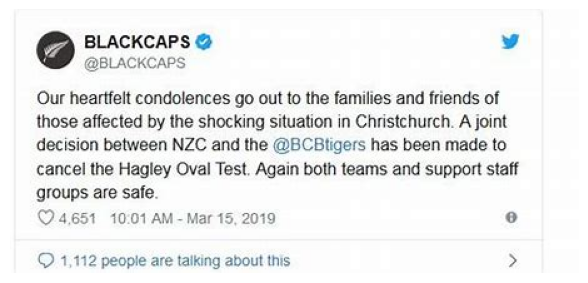

In [71]:
display(image_file2)

INVERTED IMAGE

In [72]:
inverted_image = cv2.bitwise_not(img02)
cv2.imwrite("temp/inverted02.jpg", inverted_image)

True

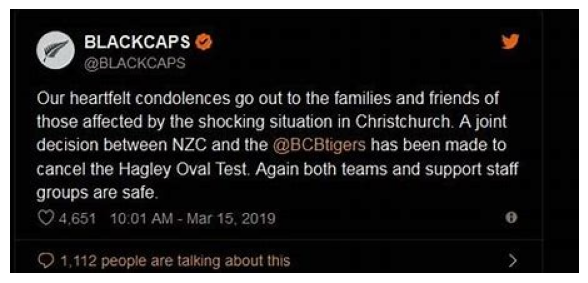

In [73]:
display("temp/inverted02.jpg")

BINARIZATION

In [74]:
def grayscale(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

In [75]:
gray_image = grayscale(img02)
cv2.imwrite("temp/gray02.jpg", gray_image)

True

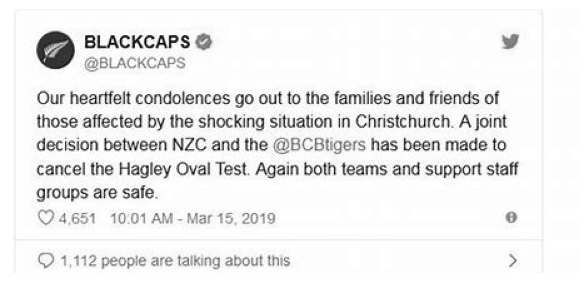

In [76]:
display("temp/gray02.jpg")

In [78]:
thresh, im_bw = cv2.threshold(gray_image, 210, 230, cv2.THRESH_BINARY)
cv2.imwrite("temp/bw_image02.jpg", im_bw)

True

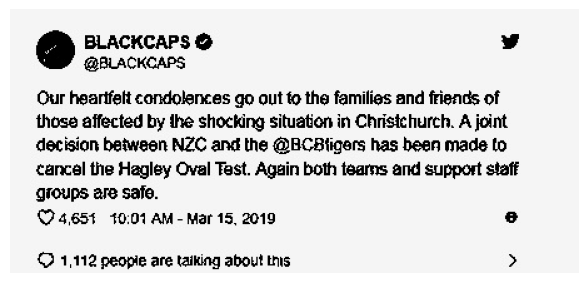

In [79]:
display("temp/bw_image02.jpg")

REMOVE NOISE

In [83]:
def noise_removal(image):
    import numpy as np
    kernel = np.ones((1, 1), np.uint8)
    image = cv2.dilate(image, kernel, iterations=1)
    kernel = np.ones((1, 1), np.uint8)
    image = cv2.erode(image, kernel, iterations=1)
    image = cv2.morphologyEx(image, cv2.MORPH_CLOSE, kernel)
    image = cv2.medianBlur(image, 1)
    return (image)

In [84]:
no_noise = noise_removal(im_bw)
cv2.imwrite("temp/no_noise02.jpg", no_noise)

True

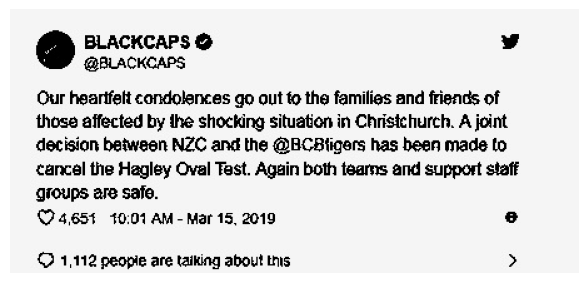

In [85]:
display("temp/no_noise02.jpg")

DILATION & EROSION

In [92]:
def thin_font(image):
    import numpy as np
    image = cv2.bitwise_not(image)
    kernel = np.ones((1,1),np.uint8)
    image = cv2.erode(image, kernel, iterations=3)
    image = cv2.bitwise_not(image)
    return (image)

In [93]:
eroded_image = thin_font(no_noise)
cv2.imwrite("temp/eroded_image02.jpg", eroded_image)

True

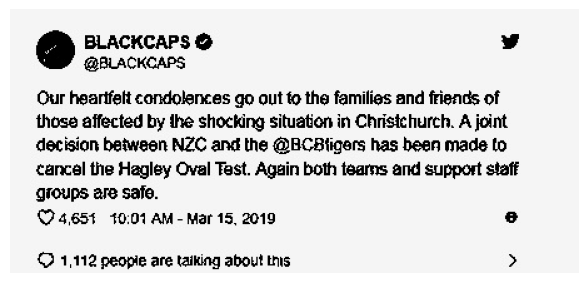

In [94]:
display("temp/eroded_image02.jpg")

In [101]:
def thick_font(image):
    import numpy as np
    image = cv2.bitwise_not(image)
    kernel = np.ones((1,1),np.uint8)
    image = cv2.dilate(image, kernel, iterations=4)
    image = cv2.bitwise_not(image)
    return (image)

In [102]:
dilated_image = thick_font(no_noise)
cv2.imwrite("temp/dilated_image02.jpg", dilated_image)

True

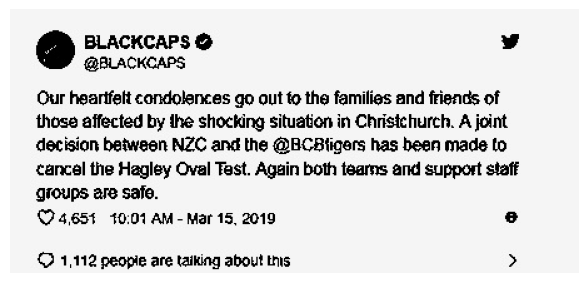

In [103]:
display("temp/dilated_image02.jpg")

Rotation/Deskewing

In [104]:
#https://becominghuman.ai/how-to-automatically-deskew-straighten-a-text-image-using-opencv-a0c30aed83df
import numpy as np

def getSkewAngle(cvImage) -> float:
    # Prep image, copy, convert to gray scale, blur, and threshold
    newImage = cvImage.copy()
    gray = cv2.cvtColor(newImage, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (9, 9), 0)
    thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]

    # Apply dilate to merge text into meaningful lines/paragraphs.
    # Use larger kernel on X axis to merge characters into single line, cancelling out any spaces.
    # But use smaller kernel on Y axis to separate between different blocks of text
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (30, 5))
    dilate = cv2.dilate(thresh, kernel, iterations=2)

    # Find all contours
    contours, hierarchy = cv2.findContours(dilate, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    contours = sorted(contours, key = cv2.contourArea, reverse = True)
    for c in contours:
        rect = cv2.boundingRect(c)
        x,y,w,h = rect
        cv2.rectangle(newImage,(x,y),(x+w,y+h),(0,255,0),2)

    # Find largest contour and surround in min area box
    largestContour = contours[0]
    print (len(contours))
    minAreaRect = cv2.minAreaRect(largestContour)
    cv2.imwrite("temp/boxes.jpg", newImage)
    # Determine the angle. Convert it to the value that was originally used to obtain skewed image
    angle = minAreaRect[-1]
    if angle < -45:
        angle = 90 + angle
    return -1.0 * angle
# Rotate the image around its center
def rotateImage(cvImage, angle: float):
    newImage = cvImage.copy()
    (h, w) = newImage.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    newImage = cv2.warpAffine(newImage, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)
    return newImage

In [105]:
# Deskew image
def deskew(cvImage):
    angle = getSkewAngle(cvImage)
    return rotateImage(cvImage, -1.0 * angle)

In [108]:
fixed = deskew(img02)
cv2.imwrite("temp/rotated_fixed.jpg", fixed)

9


True

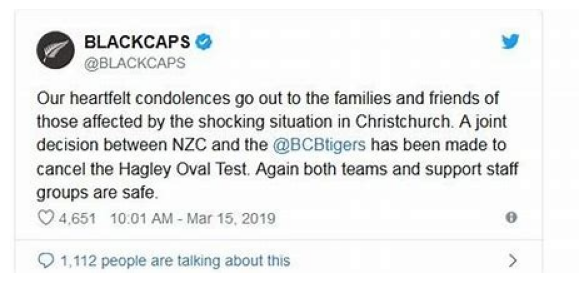

In [109]:
display("temp/rotated_fixed.jpg")

Removing Borders

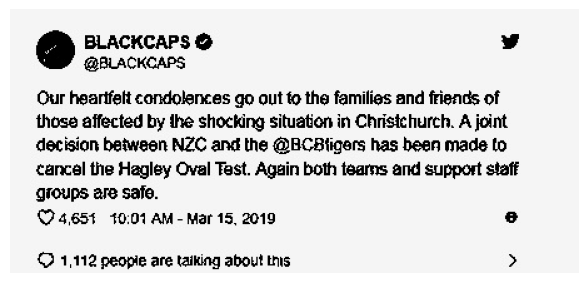

In [110]:
display("temp/no_noise02.jpg")

In [111]:
def remove_borders(image):
    contours, heiarchy = cv2.findContours(image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cntsSorted = sorted(contours, key=lambda x:cv2.contourArea(x))
    cnt = cntsSorted[-1]
    x, y, w, h = cv2.boundingRect(cnt)
    crop = image[y:y+h, x:x+w]
    return (crop)

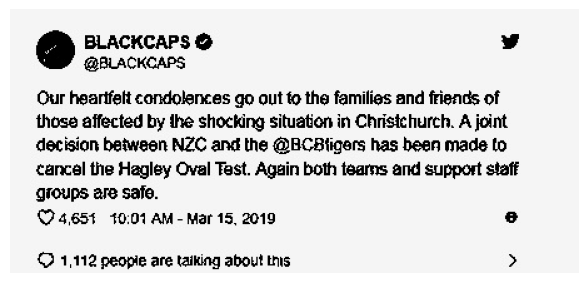

In [112]:
no_borders = remove_borders(no_noise)
cv2.imwrite("temp/no_borders02.jpg", no_borders)
display('temp/no_borders02.jpg')

MISSING BORDERS

In [117]:
color = [255, 255, 255]
top, bottom, left, right = [150]*4

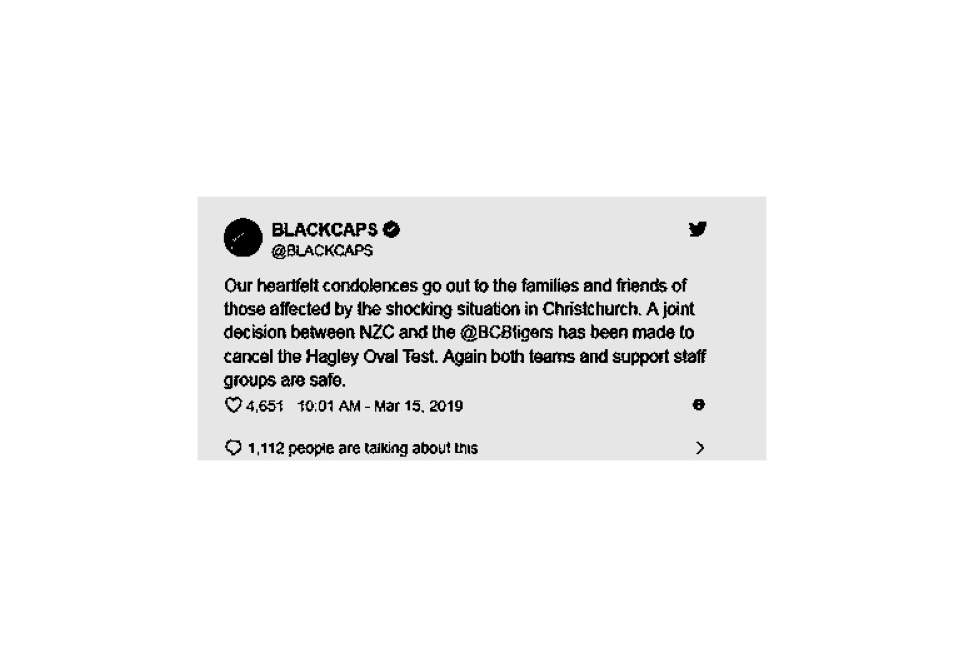

In [116]:
image_with_border = cv2.copyMakeBorder(no_borders, top, bottom, left, right, cv2.BORDER_CONSTANT, value=color)
cv2.imwrite("temp/image_with_border02.jpg", image_with_border)
display("temp/image_with_border02.jpg")